In [1]:
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

In [2]:
# (0) get the OG data 

dataDir = '../data/abs-08/'
dataTitle = 'ABS-08'
files = os.listdir(dataDir)

# we'll write up a big frame like so, 
df = pd.DataFrame(columns=['time', 'requestedRate', 'rate', 'temp', 'load'])

# from lin to vol, 
volumeScaling = math.pi * (1.75/2)**2
rawData = []
for fileName in files:
    if '.pkl' in fileName:
        continue 
    if '.csv' in fileName:
        continue 
    with open(dataDir + fileName) as file:
        fileData = json.load(file)
        for t in range(len(fileData)):
            fileData[t]['rate'] *= volumeScaling
            fileData[t]['requestedRate'] *= volumeScaling
        rawData.append(fileData)

In [3]:
# (an aside) we want to pare some out for temps-analysis, 

tdf = pd.DataFrame()

for s in range(len(rawData)):
    tdf = pd.concat([tdf, pd.DataFrame(rawData[s])], ignore_index=True)
    
tdf.describe()

fileLocation = dataDir + 'temps.pkl'
with open(fileLocation, 'wb') as file:
    pickle.dump({'df': tdf, 'title': dataTitle}, file)
    
print('saved to ' + fileLocation)

saved to ../data/abs-08/temps.pkl


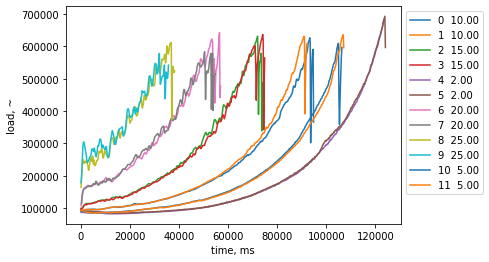

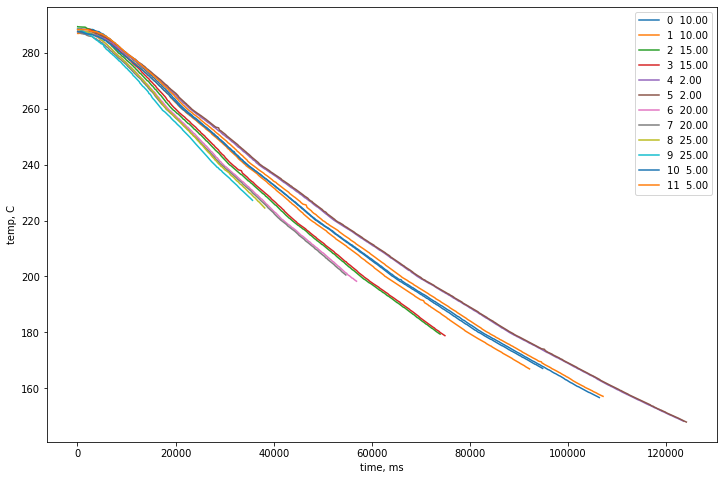

In [4]:
# (1) plot raw data 

def plotPressures(scans):
    # setup to plot 
    plt.rcParams["figure.figsize"] = (12, 4)
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('time, ms')
    ax1.set_ylabel('load, ~')
    
    for s in range(len(scans)):
        x = [] 
        y = []
        for r in range(len(scans[s])):
            x.append(scans[s][r]['time'])
            y.append(scans[s][r]['load'])

        plt.plot(x, y, label = "%d" % s + "  %.2f" % scans[s][0]['requestedRate'])
        
    ax1.legend(bbox_to_anchor=(1,1))
    
def plotPressureTemp(scans):
    # setup to plot 
    plt.rcParams["figure.figsize"] = (12, 4)
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('temp, C')
    ax1.set_ylabel('load, ~')
    
    for s in range(len(scans)):
        x = [] 
        y = []
        for r in range(len(scans[s])):
            x.append(scans[s][r]['temp'])
            y.append(scans[s][r]['load'])

        plt.plot(x, y, label = "%d" % s + "  %.2f" % scans[s][0]['requestedRate'])
        
    ax1.legend(bbox_to_anchor=(1,1))

def plotTemps(scans):
    # setup to plot 
    plt.rcParams["figure.figsize"] = (12, 8)
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('time, ms')
    ax1.set_ylabel('temp, C')
    
    for s in range(len(scans)):
        x = [] 
        y = []
        for r in range(len(scans[s])):
            x.append(scans[s][r]['time'])
            y.append(scans[s][r]['temp'])

        plt.plot(x, y, label = "%d" % s + "  %.2f" % scans[s][0]['requestedRate'])

    ax1.legend(bbox_to_anchor=(1,1))

plotPressures(rawData)
plotTemps(rawData)

In [5]:
# (2) cull borked scan lines, 

# for abs-08 
culledData = rawData #[2:]

# for pla-04 
# culledData = rawData
# del culledData[0]
# del culledData[1]
# plotPressures(culledData)

max load  635613
min load  126019.01666666668
abs min load 81808
slicing at  3  ...  110891
slicing at  6  ...  167654


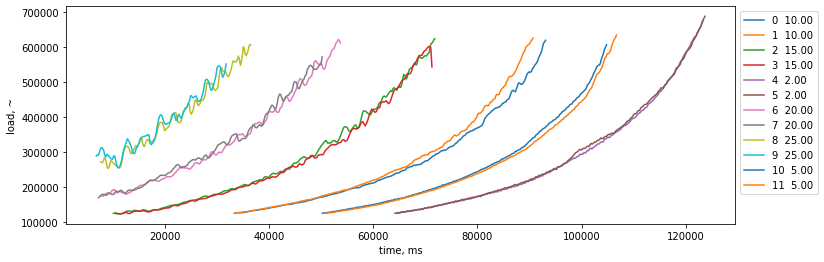

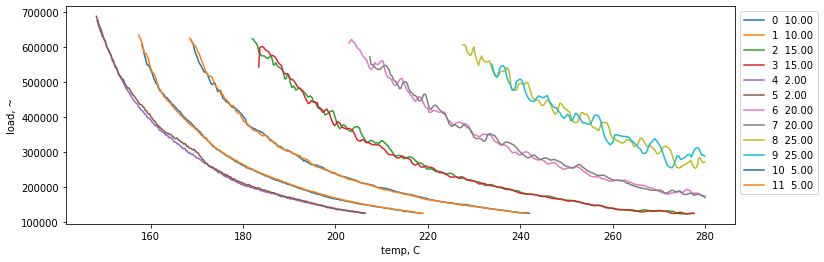

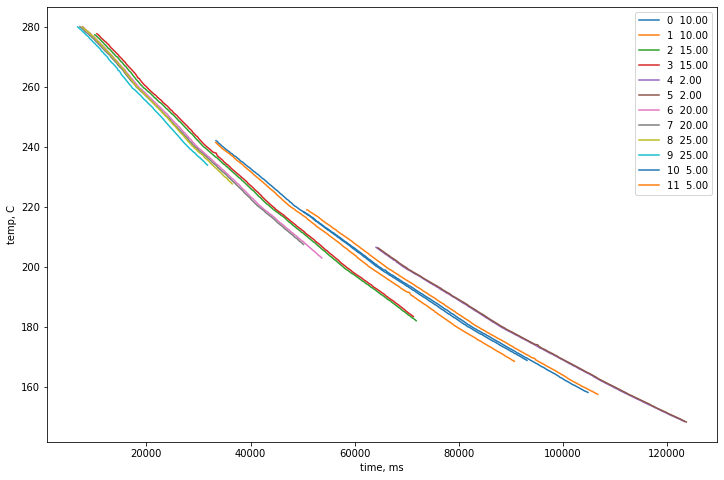

In [6]:
# (3) find min / max loads and temps, and slice on edges 

def getScanTempBounds(scan):
    minTemp = 1000 
    
    maxTemp = 0 
    for t in range(len(scan)):
        if(scan[t]['temp'] < minTemp):
            minTemp = scan[t]['temp']
        if(scan[t]['temp'] > maxTemp):
            maxTemp = scan[t]['temp']
            
    return [minTemp, maxTemp]
            
    
def getScanMaxLoad(scan):
    maxLoad = 0 
    
    for t in range(len(scan)):
        if(scan[t]['load'] > maxLoad):
            maxLoad = scan[t]['load']
            
    return maxLoad

# global max/min load, 
maxLoad = 0 
for s in range(len(culledData)):
    maxLoad += getScanMaxLoad(culledData[s])

maxLoad /= len(culledData)

# this is a pick... low-load data limit is noisy / bad 
minLoad = maxLoad * 0.2

# let's scan through for abs-max pressure in each run and cull data afterwards, 
data = []
absMinLoad = 1000000 
for s in range(len(culledData)):
    # find abs max, 
    maxLoad = 0 
    maxLoadIndice = 0 
    firstColdIndice = 0
    for t in range(len(culledData[s])):
        if(culledData[s][t]['temp'] < 280 and firstColdIndice == 0 and culledData[s][t]['load'] > minLoad):
            firstColdIndice = t
        if(culledData[s][t]['load'] > maxLoad):
            maxLoad = culledData[s][t]['load']
            maxLoadIndice = t
        if(culledData[s][t]['load'] < absMinLoad):
            absMinLoad = culledData[s][t]['load']
    # don't include low-rate (messy!) runs, 
    if(culledData[s][0]['requestedRate'] > 1):
        data.append(culledData[s][firstColdIndice:maxLoadIndice])

print("max load ", maxLoad)
print("min load ", minLoad)
print("abs min load", absMinLoad)
        
# chop big instantaneous drops 
for s in range(len(data)):
    lastLoad = 0 
    for t in range(len(data[s])):
        thisLoad = data[s][t]['load']
        if(lastLoad - thisLoad > 60000):
            print("slicing at ", s, " ... ", lastLoad - thisLoad)
            data[s] = data[s][0:t]
            break
        lastLoad = thisLoad
            
plotPressures(data)
plotPressureTemp(data)
plotTemps(data)

In [7]:
# (4) assemble a dataframe and normalize loads 

df = pd.DataFrame()

for s in range(len(data)):
    df = pd.concat([df, pd.DataFrame(data[s])], ignore_index=True)
    
# normalize 
absMaxLoad = df['load'].max()

df['load'] = (df['load'] - absMinLoad) / (absMaxLoad - absMinLoad)

df.describe()

temp         load         rate  requestedRate           time
count  3081.000000  3081.000000  3081.000000    3081.000000    3081.000000
mean    209.719952     0.354128    12.122421      11.370334   58515.009088
std      34.005014     0.223672     7.912161       7.414194   29591.443350
min     148.240463     0.070308     1.857637       2.000000    6811.000000
25%     182.780991     0.163712     5.225322       5.000000   33830.000000
50%     205.450638     0.302545    10.764093      10.000000   58205.000000
75%     236.052399     0.507109    16.331825      15.000000   81397.000000
max     279.994904     1.000000    27.345077      25.000000  123682.000000

In [8]:
# (5) finally, let's save it as a pickle, along with the scaling value... 
fileLocation = dataDir + 'cleaned.pkl'
# print(fileLocation)
with open(dataDir + 'cleaned.pkl', 'wb') as file:
    pickle.dump({'df': df, 'load_scaling': absMaxLoad - absMinLoad, 'title': dataTitle}, file)
    
print('saved to ' + fileLocation)

saved to ../data/abs-08/cleaned.pkl


In [9]:
# (6) or save it as a csv 
df.to_csv(dataDir + dataTitle + "_cleaned.csv")
print('load_scaling :', absMaxLoad - absMinLoad)

load_scaling : 606974


In [10]:
# (an aside) calculate intervals

# the intervals, 
df['intervals'] = df['time'].diff()

# removing any -ves, and between-frames (> 1000 ms)
df = df[df['intervals'].le(1000) & df['intervals'].ge(0) | df['intervals'].isna()]
df = df.reset_index(drop=True)

avg_interval = df['intervals'].mean()
print(avg_interval)
df.describe()

199.07266210492017


temp         load         rate  requestedRate           time  \
count  3070.000000  3070.000000  3070.000000    3070.000000    3070.000000   
mean    209.570316     0.354917    12.115519      11.364169   58622.702280   
std      33.921289     0.223608     7.907149       7.409778   29556.500285   
min     148.240463     0.070308     1.857637       2.000000    7032.000000   
25%     182.684986     0.164641     5.225578       5.000000   33953.500000   
50%     205.385414     0.303078    10.763767      10.000000   58350.000000   
75%     235.878166     0.508073    16.322634      15.000000   81463.250000   
max     279.718536     1.000000    27.345077      25.000000  123682.000000   

         intervals  
count  3069.000000  
mean    199.072662  
std      24.325294  
min     145.000000  
25%     184.000000  
50%     197.000000  
75%     211.000000  
max     633.000000

In [11]:
# EOF
# 
# 
# 
# 
# 
# # 
# 
# 
# 
# 
# # 
# 
# 
# 
# 
# # 
# 
# 
# 
# 
# # 
# 
# 
# 
# 
# # 
# 
# 
# 
# 
# # 
# 
# 
# 
# 
# # 
# 
# 
# 
# 
# # 
# 
# 
# 
# 
# # 
# 
# 
# 
# 
# 